### Basic code to read easterly wave tracks by Lawton et al (2022) and plot a track that matches user specified tropical storm (if available in the track database)

- Lawton, Q. A., S. J. Majumdar, K. Dotterer, C. Thorncroft, and C. J. Schreck, 2022: The Influence of Convectively Coupled Kelvin Waves on African Easterly Waves in a Wave-Following Framework. Monthly Weather Review, 150(8), 2055-2072, https://doi.org/10.1175/MWR-D-21-0321.1.

#### Then, a track following IR loop is assembled and displayed 

- NCSU Tropical and Large Scale Dynamics
- A. Aiyyer


### Other finer scale datasets: 

https://user.eumetsat.int/catalogue

### **MERGEDIR:** 4km, half hourly 
https://disc.gsfc.nasa.gov/datasets/GPM_MERGIR_1/summary?keywords=MERGEDIR. 

OpenDAP format: https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2012/200/merg_2012071800_4km-pixel.nc4.dap.nc4

In [12]:
import numpy as np
import xarray as xr
from datetime import date, timedelta, datetime
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.animation as animation
# convert the animation to javascript for display
#plt.rcParams["animation.html"] = "jshtml"
import geocat.viz.util as gvutil
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
plt.rcParams['animation.embed_limit'] = 2**128
from metpy.plots import colortables

In [13]:
# get the easterly wave track data from https://zenodo.org/records/13350860

# location of the data on the local machine:
track_data_path = "/Users/bmapes/GitHub/SkySymphony/ERA5_AEW_TRACKS/"
file_prefix = "AEW_tracks_post_processed_year_"

In [14]:
# Select storm 
storm_Name = "DOLLY"
storm_Year = 2008

# Select storm
storm_Name = "IRMA"
storm_Year = 2017

# Select storm
storm_Name = "ERNESTO"
storm_Year = 2012

# Other good long-track ones, from the time-lon perusals 
# Ian 2022, Dolly 2014, Chantal 2013, Harvey 2011 parade? Fiona 2010 parade? Fred 2009 from 40E, 
# Dolly 2008, Ike 2008 parade, Dean 2007, Ernesto 2006, Frances 2005 parade?, 
# Grace 2003, Emily or Floyd 1999

In [15]:
fileName = track_data_path +  file_prefix + str(storm_Year) + '.nc'
ds = xr.open_dataset(fileName)
ds

<xarray.Dataset> Size: 3MB
Dimensions:         (latitude: 80, longitude: 180, time: 612, system: 68)
Coordinates:
  * latitude        (latitude) float64 640B 60.0 59.0 58.0 ... -17.0 -18.0 -19.0
  * longitude       (longitude) float64 1kB -120.0 -119.0 -118.0 ... 58.0 59.0
  * time            (time) datetime64[ns] 5kB 2012-06-01 ... 2012-10-31T18:00:00
  * system          (system) float64 544B 1.0 2.0 3.0 4.0 ... 66.0 67.0 68.0
Data variables:
    AEW_lon         (system, time) float64 333kB ...
    AEW_lat         (system, time) float64 333kB ...
    AEW_lon_smooth  (system, time) float64 333kB ...
    AEW_lat_smooth  (system, time) float64 333kB ...
    AEW_strength    (system, time) float64 333kB ...
    TC_gen_time     (system) datetime64[ns] 544B ...
    TC_name         (system) <U8 2kB ...
    curv_data_mean  (time, longitude) float64 881kB ...

In [16]:
lon = ds.AEW_lon
lat = ds.AEW_lat
n_waves = lon.shape[0]
print(n_waves)

68


In [17]:
idx = np.where(ds.TC_name == storm_Name)[0]

if idx.shape == (0,):
   print ("No storm match found")
else:
    istorm = idx[0]
    print(istorm, storm_Name)

25 ERNESTO


In [18]:
#locate a specific TC
lon_s = ds.AEW_lon_smooth.isel(system=istorm).dropna(dim='time')
lat_s =  ds.AEW_lat_smooth.isel(system=istorm).dropna(dim='time')

#locate the track index where the wave becomes a TC
TC_genesis_time = ds.TC_gen_time.isel(system=istorm)
idt = np.where(lat_s.time == TC_genesis_time)[0][0]
print("Storm genesis at ", idt, TC_genesis_time.values)

Storm genesis at  50 2012-08-01T12:00:00.000000000


In [19]:
# PLOT the track of the wave + TC

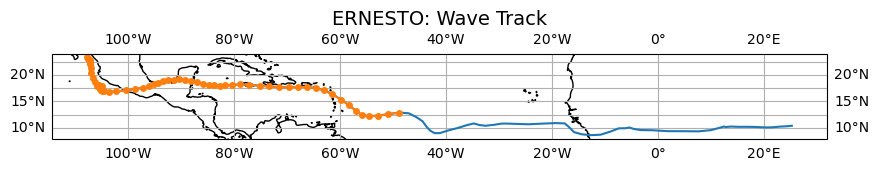

In [20]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()  # cylindrical equidistant

ax = fig.add_subplot(1, 1, 1, projection=proj)
# Add coastlines and gridlines
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot  wave track
ax.plot(lon_s, lat_s, marker='none', markersize=2, transform=ccrs.PlateCarree())
ax.plot(lon_s[idt:], lat_s[idt:], marker='o', markersize=4, transform=ccrs.PlateCarree())
plt.title(storm_Name + ": Wave Track", fontsize=14)
plt.show()

# download gridsat ir images, a centered box

In [23]:
#------------------ Center and size (+/- deg) around the central point 
dlon = 20.
dlat = 15.
    
n6htimes = lon_s.size # 6h is the wave track time step 

dates=lon_s.time.values
date0 = pd.to_datetime(dates[0])

In [25]:
# Loop from first time until last, they are 6 hourly so loop is twice that length
Images_per_6h = 2 

# Get the times and interpolated center positions
ntimes = n6htimes*Images_per_6h   # 3-hourly gridsat, equally spaced Timedelta(hours=3)
interpolated_lon = lon_s.interp(time=np.linspace(lon_s.time.values[0].astype('int64'), 
                                                 lon_s.time.values[-1].astype('int64'), 
                                                 lon_s.size * Images_per_6h).astype('datetime64[ns]'))
interpolated_lat = lat_s.interp(time=np.linspace(lat_s.time.values[0].astype('int64'), 
                                                 lat_s.time.values[-1].astype('int64'), 
                                                 lat_s.size * Images_per_6h).astype('datetime64[ns]'))

for i in range(ntimes):
    datePlot = date0 + i*pd.Timedelta(hours=3)
    YYYY = datePlot.strftime('%Y')            # Year, needed for URL
    
# if accessing from ncei
    url_base = 'https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/' + YYYY + '/'
    url = url_base + "GRIDSAT-B1."  + datePlot.strftime('%Y.%m.%d.%H')  + ".v02r01.nc"
    print(datePlot, url)

# Define center point for image at this time 
    centlon = interpolated_lon[i]; 
    centlat = interpolated_lat[i]; 

# sel() the box 
    ds = xr.open_dataset(url)
    LatIndexer, LonIndexer = 'lat', 'lon'
    dsbox = ds.sel(**{LatIndexer: slice(centlat-dlat, centlat+dlat),
                      LonIndexer: slice(centlon-dlon, centlon+dlon)})
# Write it out
    dsbox.to_netcdf('~/Box/Sky_Symphony_Box/ERNESTO12/GridSatBoxes/time'+str(i).zfill(3)+'.nc')   

2012-07-20 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.00.v02r01.nc
2012-07-20 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.03.v02r01.nc
2012-07-20 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.06.v02r01.nc
2012-07-20 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.09.v02r01.nc
2012-07-20 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.12.v02r01.nc
2012-07-20 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.15.v02r01.nc
2012-07-20 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.18.v02r01.nc
2012-07-20 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.20.21.v02r01.nc
2012-07-21 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.21.00.v0

Error:curl error: Timeout was reached
curl error details: 


2012-07-24 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.24.18.v02r01.nc


Note:Caching=1


2012-07-24 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.24.21.v02r01.nc


Note:Caching=1


2012-07-25 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.00.v02r01.nc


Note:Caching=1


2012-07-25 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.03.v02r01.nc


Note:Caching=1


2012-07-25 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.06.v02r01.nc


Note:Caching=1


2012-07-25 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.09.v02r01.nc


Note:Caching=1


2012-07-25 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.12.v02r01.nc


Note:Caching=1


2012-07-25 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.15.v02r01.nc


Note:Caching=1


2012-07-25 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.18.v02r01.nc


Note:Caching=1


2012-07-25 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.25.21.v02r01.nc


Note:Caching=1


2012-07-26 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.00.v02r01.nc


Note:Caching=1


2012-07-26 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.03.v02r01.nc


Note:Caching=1


2012-07-26 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.06.v02r01.nc


Note:Caching=1


2012-07-26 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.09.v02r01.nc


Note:Caching=1


2012-07-26 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.12.v02r01.nc


Note:Caching=1


2012-07-26 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.15.v02r01.nc


Note:Caching=1


2012-07-26 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.18.v02r01.nc


Note:Caching=1


2012-07-26 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.26.21.v02r01.nc


Note:Caching=1


2012-07-27 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.00.v02r01.nc


Note:Caching=1


2012-07-27 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.03.v02r01.nc


Note:Caching=1


2012-07-27 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.06.v02r01.nc


Note:Caching=1


2012-07-27 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.09.v02r01.nc


Note:Caching=1


2012-07-27 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.12.v02r01.nc


Note:Caching=1


2012-07-27 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.15.v02r01.nc


Note:Caching=1


2012-07-27 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.18.v02r01.nc


Note:Caching=1


2012-07-27 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.27.21.v02r01.nc


Note:Caching=1


2012-07-28 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.00.v02r01.nc


Note:Caching=1


2012-07-28 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.03.v02r01.nc


Note:Caching=1


2012-07-28 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.06.v02r01.nc


Note:Caching=1


2012-07-28 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.09.v02r01.nc


Note:Caching=1


2012-07-28 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.12.v02r01.nc


Note:Caching=1


2012-07-28 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.15.v02r01.nc


Note:Caching=1


2012-07-28 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.18.v02r01.nc


Note:Caching=1


2012-07-28 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.28.21.v02r01.nc


Note:Caching=1


2012-07-29 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.00.v02r01.nc


Note:Caching=1


2012-07-29 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.03.v02r01.nc


Note:Caching=1


2012-07-29 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.06.v02r01.nc


Note:Caching=1


2012-07-29 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.09.v02r01.nc


Note:Caching=1


2012-07-29 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.12.v02r01.nc


Note:Caching=1


2012-07-29 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.15.v02r01.nc


Note:Caching=1


2012-07-29 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.18.v02r01.nc


Note:Caching=1


2012-07-29 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.29.21.v02r01.nc


Note:Caching=1


2012-07-30 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.00.v02r01.nc


Note:Caching=1


2012-07-30 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.03.v02r01.nc


Note:Caching=1


2012-07-30 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.06.v02r01.nc


Note:Caching=1


2012-07-30 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.09.v02r01.nc


Note:Caching=1


2012-07-30 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.12.v02r01.nc


Note:Caching=1


2012-07-30 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.15.v02r01.nc


Note:Caching=1


2012-07-30 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.18.v02r01.nc


Note:Caching=1


2012-07-30 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.30.21.v02r01.nc


Note:Caching=1


2012-07-31 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.00.v02r01.nc


Note:Caching=1


2012-07-31 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.03.v02r01.nc


Note:Caching=1


2012-07-31 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.06.v02r01.nc


Note:Caching=1


2012-07-31 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.09.v02r01.nc


Note:Caching=1


2012-07-31 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.12.v02r01.nc


Note:Caching=1


2012-07-31 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.15.v02r01.nc


Note:Caching=1


2012-07-31 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.18.v02r01.nc


Note:Caching=1


2012-07-31 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.07.31.21.v02r01.nc


Note:Caching=1


2012-08-01 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.00.v02r01.nc


Note:Caching=1


2012-08-01 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.03.v02r01.nc


Note:Caching=1


2012-08-01 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.06.v02r01.nc


Note:Caching=1


2012-08-01 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.09.v02r01.nc


Note:Caching=1


2012-08-01 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.12.v02r01.nc


Note:Caching=1


2012-08-01 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.15.v02r01.nc


Note:Caching=1


2012-08-01 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.18.v02r01.nc


Note:Caching=1


2012-08-01 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.01.21.v02r01.nc


Note:Caching=1


2012-08-02 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.00.v02r01.nc


Note:Caching=1


2012-08-02 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.03.v02r01.nc


Note:Caching=1


2012-08-02 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.06.v02r01.nc


Note:Caching=1


2012-08-02 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.09.v02r01.nc


Note:Caching=1


2012-08-02 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.12.v02r01.nc


Note:Caching=1


2012-08-02 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.15.v02r01.nc


Note:Caching=1


2012-08-02 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.18.v02r01.nc


Note:Caching=1


2012-08-02 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.02.21.v02r01.nc


Note:Caching=1


2012-08-03 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.00.v02r01.nc


Note:Caching=1


2012-08-03 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.03.v02r01.nc


Note:Caching=1


2012-08-03 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.06.v02r01.nc


Note:Caching=1


2012-08-03 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.09.v02r01.nc


Note:Caching=1


2012-08-03 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.12.v02r01.nc


Note:Caching=1


2012-08-03 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.15.v02r01.nc


Note:Caching=1


2012-08-03 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.18.v02r01.nc


Note:Caching=1


2012-08-03 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.03.21.v02r01.nc


Note:Caching=1


2012-08-04 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.00.v02r01.nc


Note:Caching=1


2012-08-04 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.03.v02r01.nc


Note:Caching=1


2012-08-04 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.06.v02r01.nc


Note:Caching=1


2012-08-04 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.09.v02r01.nc


Note:Caching=1


2012-08-04 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.12.v02r01.nc


Note:Caching=1


2012-08-04 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.15.v02r01.nc


Note:Caching=1


2012-08-04 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.18.v02r01.nc


Note:Caching=1


2012-08-04 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.04.21.v02r01.nc


Note:Caching=1


2012-08-05 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.00.v02r01.nc


Note:Caching=1


2012-08-05 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.03.v02r01.nc


Note:Caching=1


2012-08-05 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.06.v02r01.nc


Note:Caching=1


2012-08-05 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.09.v02r01.nc


Note:Caching=1


2012-08-05 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.12.v02r01.nc


Note:Caching=1


2012-08-05 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.15.v02r01.nc


Note:Caching=1


2012-08-05 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.18.v02r01.nc


Note:Caching=1


2012-08-05 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.05.21.v02r01.nc


Note:Caching=1


2012-08-06 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.00.v02r01.nc


Note:Caching=1


2012-08-06 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.03.v02r01.nc


Note:Caching=1


2012-08-06 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.06.v02r01.nc


Note:Caching=1


2012-08-06 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.09.v02r01.nc


Note:Caching=1


2012-08-06 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.12.v02r01.nc


Note:Caching=1


2012-08-06 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.15.v02r01.nc


Note:Caching=1


2012-08-06 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.18.v02r01.nc


Note:Caching=1


2012-08-06 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.06.21.v02r01.nc


Note:Caching=1


2012-08-07 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.00.v02r01.nc


Note:Caching=1


2012-08-07 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.03.v02r01.nc


Note:Caching=1


2012-08-07 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.06.v02r01.nc


Note:Caching=1


2012-08-07 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.09.v02r01.nc


Note:Caching=1


2012-08-07 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.12.v02r01.nc


Note:Caching=1


2012-08-07 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.15.v02r01.nc


Note:Caching=1


2012-08-07 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.18.v02r01.nc


Note:Caching=1


2012-08-07 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.07.21.v02r01.nc


Note:Caching=1


2012-08-08 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.00.v02r01.nc


Note:Caching=1


2012-08-08 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.03.v02r01.nc


Note:Caching=1


2012-08-08 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.06.v02r01.nc


Note:Caching=1


2012-08-08 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.09.v02r01.nc


Note:Caching=1


2012-08-08 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.12.v02r01.nc


Note:Caching=1


2012-08-08 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.15.v02r01.nc


Note:Caching=1


2012-08-08 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.18.v02r01.nc


Note:Caching=1


2012-08-08 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.08.21.v02r01.nc


Note:Caching=1


2012-08-09 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.00.v02r01.nc


Note:Caching=1


2012-08-09 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.03.v02r01.nc


Note:Caching=1


2012-08-09 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.06.v02r01.nc


Note:Caching=1


2012-08-09 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.09.v02r01.nc


Note:Caching=1


2012-08-09 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.12.v02r01.nc


Note:Caching=1


2012-08-09 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.15.v02r01.nc


Note:Caching=1


2012-08-09 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.18.v02r01.nc


Note:Caching=1


2012-08-09 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.09.21.v02r01.nc


Note:Caching=1


2012-08-10 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.00.v02r01.nc


Note:Caching=1


2012-08-10 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.03.v02r01.nc


Note:Caching=1


2012-08-10 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.06.v02r01.nc


Note:Caching=1


2012-08-10 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.09.v02r01.nc


Note:Caching=1


2012-08-10 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.12.v02r01.nc


Note:Caching=1


2012-08-10 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.15.v02r01.nc


Note:Caching=1


2012-08-10 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.18.v02r01.nc


Note:Caching=1


2012-08-10 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.10.21.v02r01.nc


Note:Caching=1


2012-08-11 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.00.v02r01.nc


Note:Caching=1


2012-08-11 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.03.v02r01.nc


Note:Caching=1


2012-08-11 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.06.v02r01.nc


Note:Caching=1


2012-08-11 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.09.v02r01.nc


Note:Caching=1


2012-08-11 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.12.v02r01.nc


Note:Caching=1


2012-08-11 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.15.v02r01.nc


Note:Caching=1


2012-08-11 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.18.v02r01.nc


Note:Caching=1


2012-08-11 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.11.21.v02r01.nc


Note:Caching=1


2012-08-12 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.00.v02r01.nc


Note:Caching=1


2012-08-12 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.03.v02r01.nc


Note:Caching=1


2012-08-12 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.06.v02r01.nc


Note:Caching=1


2012-08-12 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.09.v02r01.nc


Note:Caching=1


2012-08-12 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.12.v02r01.nc


Note:Caching=1


2012-08-12 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.15.v02r01.nc


Note:Caching=1


2012-08-12 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.18.v02r01.nc


Note:Caching=1


2012-08-12 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.12.21.v02r01.nc


Note:Caching=1


2012-08-13 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.00.v02r01.nc


Note:Caching=1


2012-08-13 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.03.v02r01.nc


Note:Caching=1


2012-08-13 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.06.v02r01.nc


Note:Caching=1


2012-08-13 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.09.v02r01.nc


Note:Caching=1


2012-08-13 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.12.v02r01.nc


Note:Caching=1


2012-08-13 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.15.v02r01.nc


Note:Caching=1


2012-08-13 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.18.v02r01.nc


Note:Caching=1


2012-08-13 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.13.21.v02r01.nc


Note:Caching=1


2012-08-14 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.00.v02r01.nc


Note:Caching=1


2012-08-14 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.03.v02r01.nc


Note:Caching=1


2012-08-14 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.06.v02r01.nc


Note:Caching=1


2012-08-14 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.09.v02r01.nc


Note:Caching=1


2012-08-14 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.12.v02r01.nc


Note:Caching=1


2012-08-14 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.15.v02r01.nc


Note:Caching=1


2012-08-14 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.18.v02r01.nc


Note:Caching=1


2012-08-14 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.14.21.v02r01.nc


Note:Caching=1


2012-08-15 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.00.v02r01.nc


Note:Caching=1


2012-08-15 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.03.v02r01.nc


Note:Caching=1


2012-08-15 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.06.v02r01.nc


Note:Caching=1


2012-08-15 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.09.v02r01.nc


Note:Caching=1


2012-08-15 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.12.v02r01.nc


Note:Caching=1


2012-08-15 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.15.v02r01.nc


Note:Caching=1


2012-08-15 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.18.v02r01.nc


Note:Caching=1


2012-08-15 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.15.21.v02r01.nc


Note:Caching=1


2012-08-16 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.00.v02r01.nc


Note:Caching=1


2012-08-16 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.03.v02r01.nc


Note:Caching=1


2012-08-16 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.06.v02r01.nc


Note:Caching=1


2012-08-16 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.09.v02r01.nc


Note:Caching=1


2012-08-16 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.12.v02r01.nc


Note:Caching=1


2012-08-16 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.15.v02r01.nc


Note:Caching=1


2012-08-16 18:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.18.v02r01.nc


Note:Caching=1


2012-08-16 21:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.16.21.v02r01.nc


Note:Caching=1


2012-08-17 00:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.00.v02r01.nc


Note:Caching=1


2012-08-17 03:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.03.v02r01.nc


Note:Caching=1


2012-08-17 06:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.06.v02r01.nc


Note:Caching=1


2012-08-17 09:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.09.v02r01.nc


Note:Caching=1


2012-08-17 12:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.12.v02r01.nc


Note:Caching=1


2012-08-17 15:00:00 https://www.ncei.noaa.gov/thredds/dodsC/cdr/gridsat/2012/GRIDSAT-B1.2012.08.17.15.v02r01.nc


Note:Caching=1
